This is a useful tool for analyzing existing trends in observed temperatures over a given period for any state in the US. The following steps are implemented in the code:

1. **Download gridded temperature data** for the entire US for each year within the specified time period.
2. **Calculate timeseries** of annual minimum, maximum, or average temperatures for each grid.
3. **Download the shapefile** of the user-specified state in the US.
4. **Crop the temperature data** using the shapefile obtained in Step 3.
5. **Perform statistical analysis** to identify any significant trends in the time series specified by the user.
6. **Visualize the trend** and summarize its statistical significance using a specified confidence interval.

<font size="5">**Required libraries**</font>

First part of the code is to import the necessary libraries.

In [49]:
import os
import glob
import matplotlib.pyplot as plt
import urllib.request
import xarray as xr
import calendar
import zipfile
import requests
import io
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import statsmodels.api as sm
from scipy import stats

<font size="5">**Functions**</font>

Following the importation of necessary libraries, several essential **functions**—frequently utilized throughout the code—are defined. These functions facilitate the downloading and formatting of datasets, manage the retrieval and reprojection of the shapefile corresponding to the user-specified state (with California as the default), and ultimately perform cropping of the dataset based on the state-specific shapefile.

In [52]:
## download gridded data and load the dataset
def download(url, savename):
    if os.path.exists(f"./{savename}") is not True:
        urllib.request.urlretrieve(url, savename)
    ds = xr.open_dataset(savename)
    return ds

## Implement a few required adjustments to the dataset
def dataset_adjustment(ds):
    ds_adjusted = ds.rename({'day':'time' , 'air_temperature':'temp'})
    ds_adjusted = (ds_adjusted-273.15)*1.8 + 32 # Convert Kelvin to Fahrenheit
    return ds_adjusted

## Download and reproject the shapefile of the State, for which the trend analysis is needed
def geo_dataframe(state='California'):
    ## Download and Load the Shapefile for all US States
    url_states = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
    response_states = requests.get(url_states)
    with zipfile.ZipFile(io.BytesIO(response_states.content)) as z:
        z.extractall("cb_2022_us_state_20m")
    ## Load the shapefile
    shapefile_path = "cb_2022_us_state_20m/cb_2022_us_state_20m.shp"
    gdf_states = gpd.read_file(shapefile_path)
    ## Filter the GeoDataFrame to include only the specified State
    gdf = gdf_states[gdf_states['NAME'] == state.capitalize()]
    ## Reproject the Shapefile to match the CRS of the temperature data
    # Assume CRS of temperature data is EPSG:4326
    gdf = gdf.to_crs(epsg=4326)
    return gdf
    
## Crop the temeprature dataset by the shapefile of the given State
def clip_by_shapefile(ds, gdf_shapefile, yr):
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)
    clipped_nc = ds.rio.clip(gdf_shapefile.geometry.apply(mapping), gdf_shapefile.crs, drop=True)
    clipped_nc.to_netcdf(f"clipped_file_{yr}.nc")
    return clipped_nc

<font size="5">**Statistical Trend Analysis**</font>

Upon processing the data, the subsequent statistical trend analysis is conducted. The provided function executes this analysis, visualizing the annual data alongside a fitted linear regression line. Additionally, it displays the confidence interval and reports the statistical significance of the observed trend. By default, the analysis spans the period from 2000 to 2020, with a confidence interval set at 0.05.

In [55]:
def statistical_trend_analysis(var_name, start_year = 2000, stop_year = 2020, ci = 0.05, print_full_summary = False):
    global State
    x = [x for x in range(start_year, stop_year+1)]
    y = globals()[var_name]
    
    # Prepare the data for linear regression
    X = sm.add_constant(x)  # Adds a constant term for the intercept
    model = sm.OLS(y, X).fit()

    if print_full_summary:
        # Print the model summary to get p-value and other statistics
        print(model.summary())

    # Extract the p-value for the slope
    p_value = model.pvalues[1]  # p-value for the slope coefficient

    # Set significance level
    CI = ci
    
    # Determine if the trend is statistically significant
    if p_value < CI:
        print(f"\033[1mThe trend is statistically significant (p-value = {p_value:.4f}).\033[0m") # print in bold font
    else:
        print(f"\033[1mThe trend is not statistically significant (p-value = {p_value:.4f}).\033[0m") # print in bold font

    # Get the predicted values and confidence intervals
    predictions = model.get_prediction(X)
    pred_summary = predictions.summary_frame(alpha=CI)  # 95% confidence interval

    # Extract confidence intervals
    conf_int = pred_summary[['obs_ci_lower', 'obs_ci_upper']]

    # Plot the data and the trend line with confidence intervals
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, color='blue', label = var_name.replace('state',State), marker = 'o')
    plt.plot(x, model.fittedvalues, color = 'red', label = 'Trend Line', linestyle = 'dashed')
    plt.fill_between(x, conf_int['obs_ci_lower'], conf_int['obs_ci_upper'], color = 'pink', alpha=0.3, label=f'{1-CI}% Confidence Interval')
    plt.xlabel('')
    plt.xticks([int(i) for i in range(start_year, stop_year+1, 2)])
    plt.ylabel('Air temperature (Tmin, °F)', fontsize = 12, fontweight = 'bold')
    plt.title(f'Trend Analysis for {State}', fontsize = 12, fontweight = 'bold')
    plt.legend()
    plt.show()

<font size="5">**Main body of the code**</font>

This section conducts a trend analysis for California using the observed temperature dataset spanning 2000 to 2020. It executes various functions, processing their outputs throughout the code. Ultimately, it generates three distinct plots illustrating the statistical trend analysis for: 1) minimum temperature, 2) maximum temperature, and 3) average temperature across California. The code is available for download and can be executed to perform similar analyses for other states.

The trend is statistically significant (p-value = 0.0130).


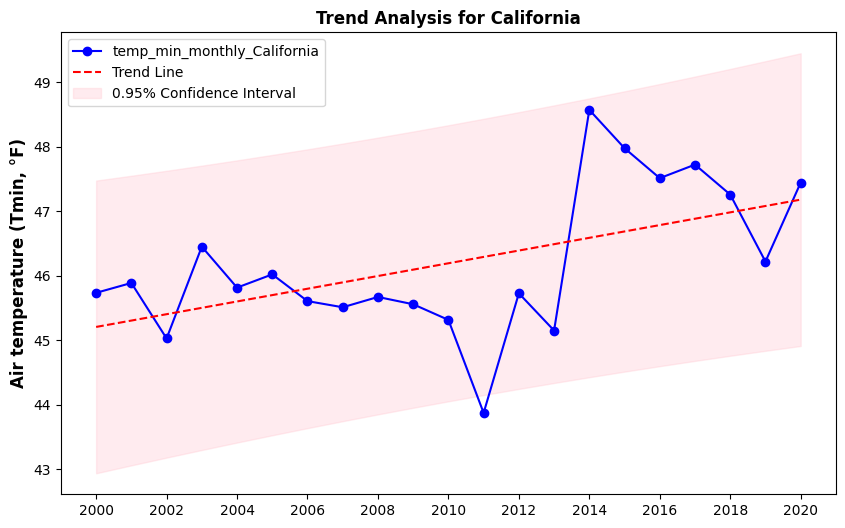

The trend is not statistically significant (p-value = 0.1467).


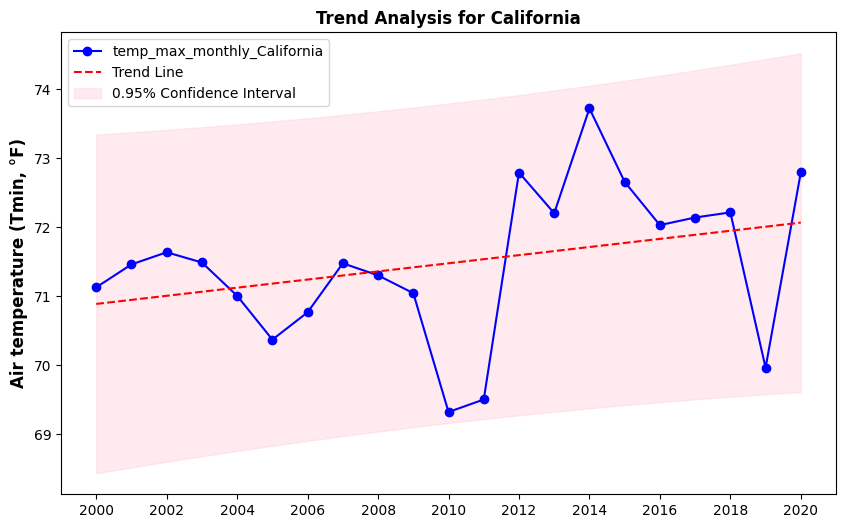

The trend is statistically significant (p-value = 0.0320).


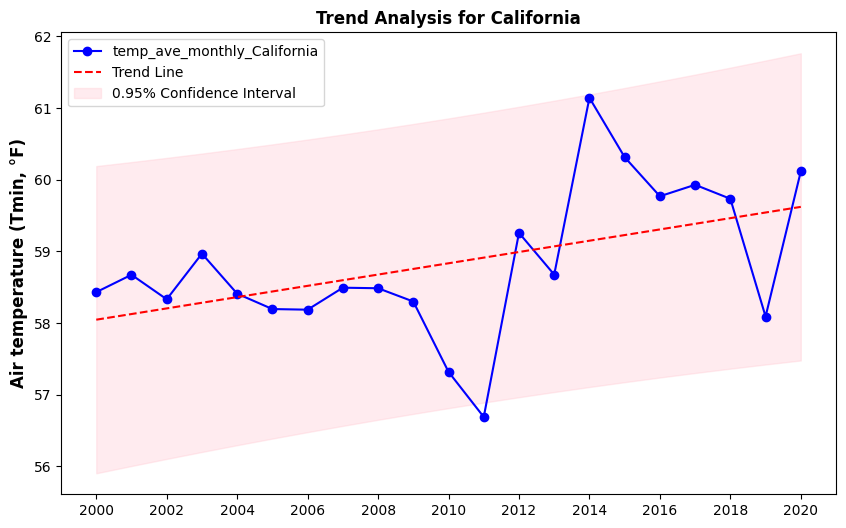

In [58]:
State = 'California'
gdf_shp = geo_dataframe(State)

temp_ave_monthly_state = []
temp_min_monthly_state = []
temp_max_monthly_state = []
start_year = 2000
stop_year = 2020
for yr in range(start_year,stop_year+1):
    #print(yr)
    url_base = "https://www.northwestknowledge.net/metdata/data/"
    
    # download and process the min temperature
    url_min = url_base + f"tmmn_{yr}.nc"
    savename = f'tmin_gridmet_{yr}.nc'
    temp_min = download(url_min, savename)
    temp_min_adjusted = dataset_adjustment(temp_min)
    
    # download and process the max temperature
    url_max = url_base + f"tmmx_{yr}.nc"
    savename = f'tmax_gridmet_{yr}.nc'
    temp_max = download(url_max, savename)
    temp_max_adjusted = dataset_adjustment(temp_max)

    # calculate the mean monthly temperature per grid
    temp_ave = temp_max_adjusted.copy()
    temp_ave['temp'] = (temp_min_adjusted['temp'] + temp_max_adjusted['temp'])/2
    temp_ave_monthly = temp_ave.groupby('time.month').mean()

    # clip the temperature data for the State of interest
    # mean temp
    clipped_nc_temp_ave = clip_by_shapefile(temp_ave_monthly, gdf_shp, yr)
    temp_ave_monthly_state.append(clipped_nc_temp_ave.temp.mean().values)
    # min temp
    temp_min_adjusted_mon = temp_min_adjusted.groupby('time.month').mean()
    clipped_nc_temp_min = clip_by_shapefile(temp_min_adjusted_mon, gdf_shp, yr)
    temp_min_monthly_state.append(clipped_nc_temp_min.temp.mean().values)
    # max temp
    temp_max_adjusted_mon = temp_max_adjusted.groupby('time.month').mean()
    clipped_nc_temp_max = clip_by_shapefile(temp_max_adjusted_mon, gdf_shp, yr)
    temp_max_monthly_state.append(clipped_nc_temp_max.temp.mean().values)

#implement trend analysis
ci = 0.05
statistical_trend_analysis('temp_min_monthly_state', start_year, stop_year, ci, False)
statistical_trend_analysis('temp_max_monthly_state', start_year, stop_year, ci, False)
statistical_trend_analysis('temp_ave_monthly_state', start_year, stop_year, ci, False)